In [12]:
import yfinance as yf
import pandas as pd
from pandas import DataFrame as df
df = yf.download("AMZN", start="2020-01-01", end="2023-01-01")

C:\Users\Eli Hernandez\AppData\Local\Temp\ipykernel_34268\926030036.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AMZN", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [13]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
print(df.tail())

Price            Open       High        Low      Close    Volume
Ticker           AMZN       AMZN       AMZN       AMZN      AMZN
Date                                                            
2022-12-23  83.250000  85.779999  82.930000  85.250000  57433700
2022-12-27  84.970001  85.349998  83.000000  83.040001  57284000
2022-12-28  82.800003  83.480003  81.690002  81.820000  58228600
2022-12-29  82.870003  84.550003  82.550003  84.180000  54995900
2022-12-30  83.120003  84.050003  82.470001  84.000000  62401200


In [25]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['Close'])
df['SMA_20'] = df['Close'].rolling(20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Daily return
df['Daily_Return'] = df['Close'].pct_change()

df.dropna(inplace=True)
print(df.tail())

Price            Open       High        Low      Close    Volume        RSI  \
Ticker           AMZN       AMZN       AMZN       AMZN      AMZN              
Date                                                                          
2022-12-23  83.250000  85.779999  82.930000  85.250000  57433700  37.681773   
2022-12-27  84.970001  85.349998  83.000000  83.040001  57284000  38.589574   
2022-12-28  82.800003  83.480003  81.690002  81.820000  58228600  36.073825   
2022-12-29  82.870003  84.550003  82.550003  84.180000  54995900  37.309752   
2022-12-30  83.120003  84.050003  82.470001  84.000000  62401200  39.044345   

Price          SMA_20     EMA_20 Daily_Return  
Ticker                                         
Date                                           
2022-12-23  89.827499  89.419672     0.017425  
2022-12-27  89.282000  88.812084    -0.025924  
2022-12-28  88.752000  88.146172    -0.014692  
2022-12-29  88.134000  87.768441     0.028844  
2022-12-30  87.559000  87.40954

In [26]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

In [27]:
feature_cols = ['RSI', 'SMA_20', 'EMA_20', 'Daily_Return']
X = df[feature_cols]
y = df['Target']

In [28]:
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
from sklearn.model_selection import train_test_split
# Drop rows with NaNs (due to rolling indicators)
X = X.dropna()
y = y.loc[X.index]
# Split by time — 80% train, 20% test
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5202702702702703

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.21      0.32        81
           1       0.48      0.90      0.63        67

    accuracy                           0.52       148
   macro avg       0.60      0.55      0.48       148
weighted avg       0.61      0.52      0.46       148



In [42]:
# Reconstruct test date index
df_test = df.loc[X_test.index]

# Add predictions
df_test = df_test.copy()
df_test['Prediction'] = y_pred

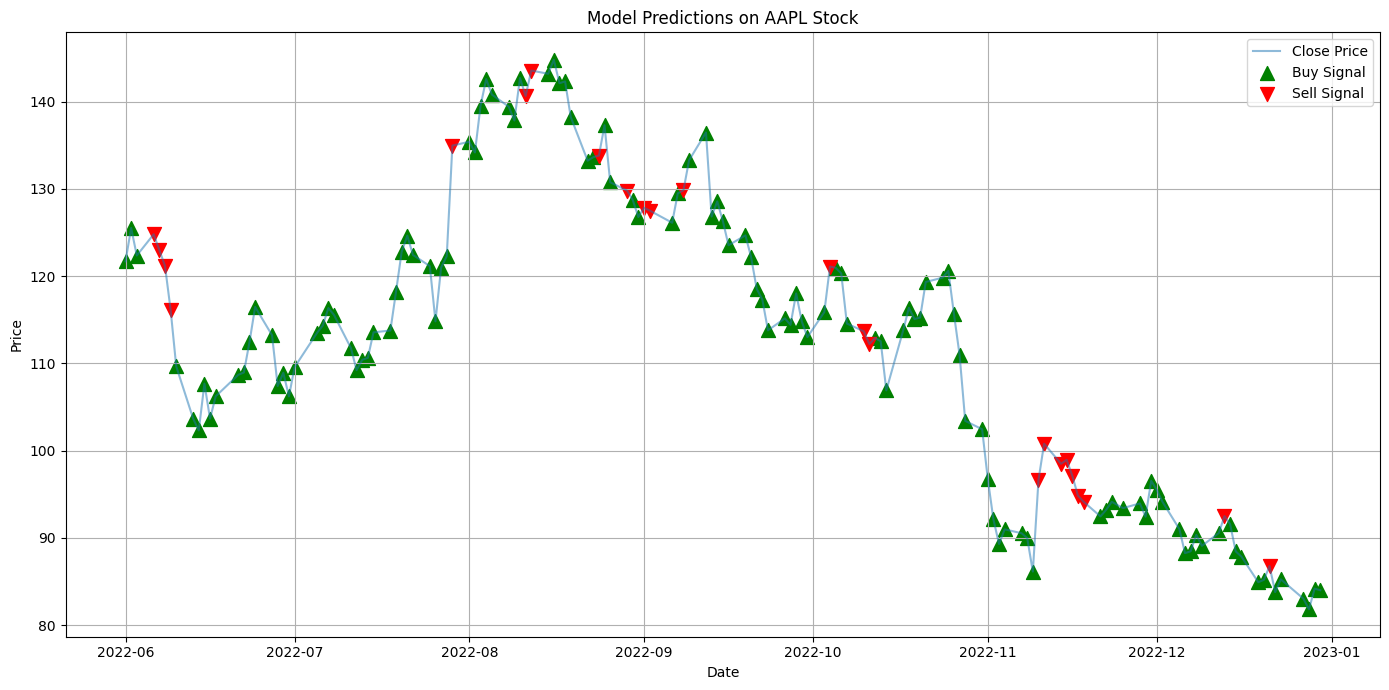

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_test.index, df_test['Close'], label='Close Price', alpha=0.5)

# Buy signals (model predicts 1 and actual was 1)
buy_signals = df_test[(df_test['Prediction'] == 1)]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)

# Sell signals (model predicts 0 and actual was 0)
sell_signals = df_test[(df_test['Prediction'] == 0)]
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

plt.title("Model Predictions on AAPL Stock")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
import torch
import numpy as np

# Only using normalized features including 'Close'
all_features = ['RSI', 'SMA_20', 'EMA_20', 'Daily_Return', 'Close']

data = df[all_features].dropna().values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Use past N days to predict the next day's close
SEQ_LEN = 20

X_seq = []
y_seq = []

for i in range(len(data_scaled) - SEQ_LEN):
    X_seq.append(data_scaled[i:i+SEQ_LEN])
    y_seq.append(data_scaled[i+SEQ_LEN][-1])  # Next day's "Close" value

X_seq = np.array(X_seq, dtype=np.float32)
y_seq = np.array(y_seq, dtype=np.float32)

In [46]:
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split train/test
split_idx = int(len(X_seq) * 0.8)
train_ds = StockDataset(X_seq[:split_idx], y_seq[:split_idx])
test_ds = StockDataset(X_seq[split_idx:], y_seq[split_idx:])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

In [47]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step
        return self.linear(out)

model = LSTMRegressor(input_size=X_seq.shape[2])

In [48]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.0820
Epoch 2/20, Loss: 0.0661
Epoch 3/20, Loss: 0.0362
Epoch 4/20, Loss: 0.0332
Epoch 5/20, Loss: 0.0244
Epoch 6/20, Loss: 0.0225
Epoch 7/20, Loss: 0.0298
Epoch 8/20, Loss: 0.0146
Epoch 9/20, Loss: 0.0108
Epoch 10/20, Loss: 0.0153
Epoch 11/20, Loss: 0.0222
Epoch 12/20, Loss: 0.0188
Epoch 13/20, Loss: 0.0120
Epoch 14/20, Loss: 0.0279
Epoch 15/20, Loss: 0.0325
Epoch 16/20, Loss: 0.0135
Epoch 17/20, Loss: 0.0223
Epoch 18/20, Loss: 0.0178
Epoch 19/20, Loss: 0.0124
Epoch 20/20, Loss: 0.0127


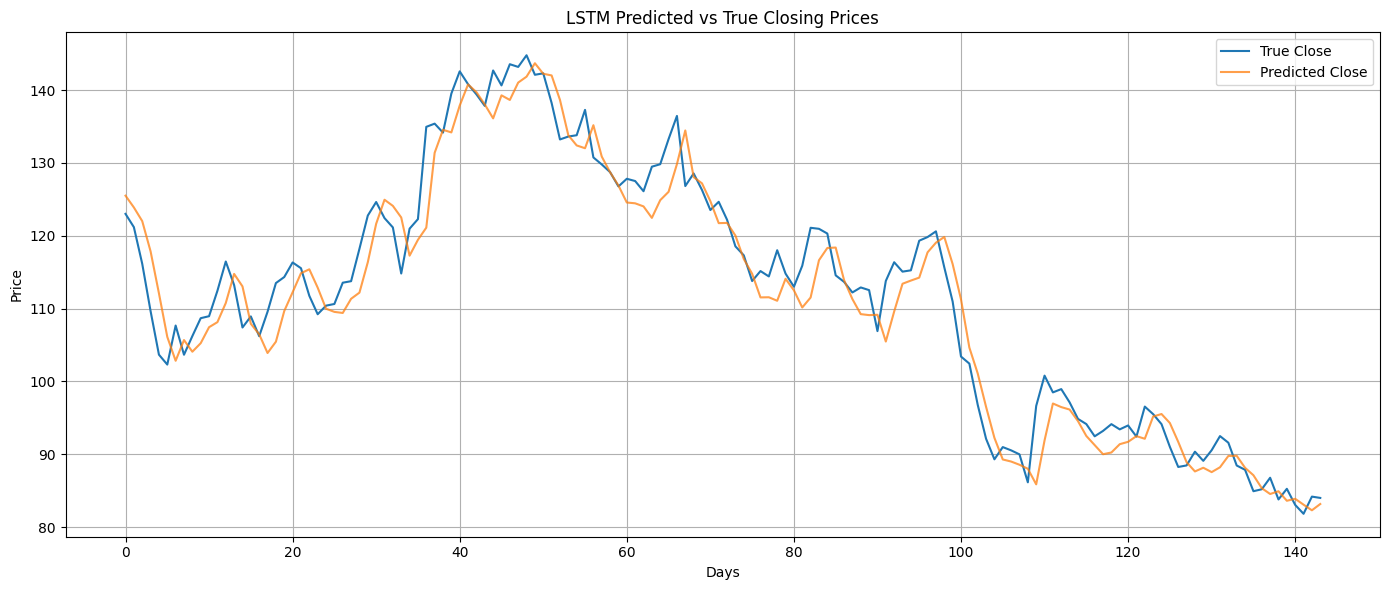

In [49]:
model.eval()
predictions = []

with torch.no_grad():
    for xb, _ in test_dl:
        pred = model(xb)
        predictions.append(pred.numpy())

predictions = np.vstack(predictions)

# Inverse transform to get actual price scale
close_index = all_features.index('Close')
true_close_scaled = y_seq[split_idx:]
full = np.zeros((len(true_close_scaled), len(all_features)))
full[:, close_index] = true_close_scaled
true_close = scaler.inverse_transform(full)[:, close_index]

full_pred = np.zeros((len(predictions), len(all_features)))
full_pred[:, close_index] = predictions.flatten()
pred_close = scaler.inverse_transform(full_pred)[:, close_index]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(true_close, label="True Close")
plt.plot(pred_close, label="Predicted Close", alpha=0.75)
plt.legend()
plt.title("LSTM Predicted vs True Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
def train_lstm_model(config, X_seq, y_seq):
    from torch.utils.data import DataLoader

    split_idx = int(len(X_seq) * 0.8)
    train_ds = StockDataset(X_seq[:split_idx], y_seq[:split_idx])
    val_ds = StockDataset(X_seq[split_idx:], y_seq[split_idx:])

    train_dl = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=config['batch_size'])

    model = LSTMRegressor(
        input_size=X_seq.shape[2],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers']
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    loss_fn = nn.MSELoss()

    for epoch in range(config['epochs']):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            pred = model(xb)
            all_preds.append(pred)
            all_targets.append(yb)

    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()
    rmse = np.sqrt(np.mean((preds - targets) ** 2))
    return rmse, config


In [51]:
import random

param_space = {
    'SEQ_LEN': [10, 20, 30],
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'epochs': [20]
}

def sample_config():
    return {k: random.choice(v) for k, v in param_space.items()}

results = []
NUM_TRIALS = 10

for trial in range(NUM_TRIALS):
    config = sample_config()
    print(f"Trial {trial+1}/{NUM_TRIALS} with config: {config}")

    # Prepare new sequences for each SEQ_LEN
    SEQ_LEN = config['SEQ_LEN']
    X_seq, y_seq = [], []
    for i in range(len(data_scaled) - SEQ_LEN):
        X_seq.append(data_scaled[i:i+SEQ_LEN])
        y_seq.append(data_scaled[i+SEQ_LEN][-1])
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)

    rmse, used_config = train_lstm_model(config, X_seq, y_seq)
    results.append((rmse, used_config))
    print(f"→ RMSE: {rmse:.4f}\n")

# Sort and show best config
results.sort(key=lambda x: x[0])
print("🏆 Best Configuration:")
print(results[0][1])
print(f"Lowest RMSE: {results[0][0]:.4f}")

Trial 1/10 with config: {'SEQ_LEN': 10, 'hidden_size': 128, 'num_layers': 1, 'batch_size': 16, 'learning_rate': 0.0005, 'epochs': 20}
→ RMSE: 0.1386

Trial 2/10 with config: {'SEQ_LEN': 20, 'hidden_size': 128, 'num_layers': 2, 'batch_size': 16, 'learning_rate': 0.001, 'epochs': 20}
→ RMSE: 0.1508

Trial 3/10 with config: {'SEQ_LEN': 20, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 32, 'learning_rate': 0.0005, 'epochs': 20}
→ RMSE: 0.1592

Trial 4/10 with config: {'SEQ_LEN': 10, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 32, 'learning_rate': 0.0005, 'epochs': 20}
→ RMSE: 0.1508

Trial 5/10 with config: {'SEQ_LEN': 30, 'hidden_size': 128, 'num_layers': 1, 'batch_size': 16, 'learning_rate': 0.0005, 'epochs': 20}
→ RMSE: 0.1405

Trial 6/10 with config: {'SEQ_LEN': 30, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 20}
→ RMSE: 0.1408

Trial 7/10 with config: {'SEQ_LEN': 10, 'hidden_size': 128, 'num_layers': 1, 'batch_size': 16, 'learning_

In [52]:
Best_config = {'SEQ_LEN': 10, 'hidden_size': 128, 'num_layers': 1, 'batch_size': 16, 'learning_rate': 0.0005, 'epochs': 20}

In [54]:
import optuna
import torch
from torch.utils.data import DataLoader

def objective(trial):
    # Sample hyperparameters
    seq_len = trial.suggest_int("seq_len", 10, 60)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    epochs = 20

    # Rebuild sequence data
    X_seq, y_seq = [], []
    for i in range(len(data_scaled) - seq_len):
        X_seq.append(data_scaled[i:i+seq_len])
        y_seq.append(data_scaled[i+seq_len][-1])
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)

    # Train/val split
    split_idx = int(len(X_seq) * 0.8)
    train_ds = StockDataset(X_seq[:split_idx], y_seq[:split_idx])
    val_ds = StockDataset(X_seq[split_idx:], y_seq[split_idx:])

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    # Model
    model = LSTMRegressor(input_size=X_seq.shape[2], hidden_size=hidden_size, num_layers=num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds, targets = [], []
        for xb, yb in val_dl:
            pred = model(xb)
            preds.append(pred)
            targets.append(yb)

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    rmse = np.sqrt(np.mean((preds - targets) ** 2))

    return rmse

In [55]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial.params)
print(f"Lowest RMSE: {study.best_value:.4f}")


[I 2025-06-14 18:12:25,057] A new study created in memory with name: no-name-9268aebe-0f0b-4f07-9a6e-5b9c0ac967e8
C:\Users\Eli Hernandez\AppData\Local\Temp\ipykernel_34268\812979801.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-06-14 18:12:28,619] Trial 0 finished with value: 0.1695736199617386 and parameters: {'seq_len': 16, 'hidden_size': 64, 'num_layers': 3, 'batch_size': 64, 'lr': 0.0010834846728878709}. Best is trial 0 with value: 0.1695736199617386.
[I 2025-06-14 18:12:43,955] Trial 1 finished with value: 0.3389701545238495 and parameters: {'seq_len': 56, 'hidden_size': 32, 'num_layers': 3, 'batch_size': 16, 'lr': 0.00048234752997678126}. Best is trial 0 with value: 0.1695736199617386.
[I 2025-06-14 18:13:07,231] Trial 2 finished with value: 0.14732

Best trial:
{'seq_len': 10, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 64, 'lr': 0.0050704299184777596}
Lowest RMSE: 0.1374


In [56]:
best_trial = {'seq_len': 10, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 64, 'lr': 0.0050704299184777596}